In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/liver-cirrhsis-stage/liver_cirrhosis.csv


In [2]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd 
data_frame=pd.read_csv("/kaggle/input/liver-cirrhsis-stage/liver_cirrhosis.csv")
print(data_frame.shape)
print("-"*50,"Difference line","-"*50)
data_frame.head(5)

(25000, 19)
-------------------------------------------------- Difference line --------------------------------------------------


,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,2221,C,Placebo,18499,F,N,Y,N,N,0.5,149.0,4.04,227.0,598.0,52.70,57.0,256.0,9.9,1
1,1230,C,Placebo,19724,M,Y,N,Y,N,0.5,219.0,3.93,22.0,663.0,45.00,75.0,220.0,10.8,2
2,4184,C,Placebo,11839,F,N,N,N,N,0.5,320.0,3.54,51.0,1243.0,122.45,80.0,225.0,10.0,2
3,2090,D,Placebo,16467,F,N,N,N,N,0.7,255.0,3.74,23.0,1024.0,77.50,58.0,151.0,10.2,2
4,2105,D,Placebo,21699,F,N,Y,N,N,1.9,486.0,3.54,74.0,1052.0,108.50,109.0,151.0,11.5,1


In [4]:
data_frame.columns

Index(['N_Days', 'Status', 'Drug', 'Age', 'Sex', 'Ascites', 'Hepatomegaly',
       'Spiders', 'Edema', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper',
       'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin',
       'Stage'],
      dtype='object')

# ***DATA PREPROCESSING***

In [5]:
data_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   N_Days         25000 non-null  int64  
 1   Status         25000 non-null  object 
 2   Drug           25000 non-null  object 
 3   Age            25000 non-null  int64  
 4   Sex            25000 non-null  object 
 5   Ascites        25000 non-null  object 
 6   Hepatomegaly   25000 non-null  object 
 7   Spiders        25000 non-null  object 
 8   Edema          25000 non-null  object 
 9   Bilirubin      25000 non-null  float64
 10  Cholesterol    25000 non-null  float64
 11  Albumin        25000 non-null  float64
 12  Copper         25000 non-null  float64
 13  Alk_Phos       25000 non-null  float64
 14  SGOT           25000 non-null  float64
 15  Tryglicerides  25000 non-null  float64
 16  Platelets      25000 non-null  float64
 17  Prothrombin    25000 non-null  float64
 18  Stage 

In [6]:
data_frame.isnull().sum()

N_Days           0
Status           0
Drug             0
Age              0
Sex              0
Ascites          0
Hepatomegaly     0
Spiders          0
Edema            0
Bilirubin        0
Cholesterol      0
Albumin          0
Copper           0
Alk_Phos         0
SGOT             0
Tryglicerides    0
Platelets        0
Prothrombin      0
Stage            0
dtype: int64

In [7]:
distinct_categories_1 = data_frame['Status'].unique()
print(distinct_categories_1)

['C' 'D' 'CL']


In [8]:
distinct_categories_2 = data_frame['Drug'].unique()
print(distinct_categories_2)

['Placebo' 'D-penicillamine']


In [9]:
distinct_categories_3 = data_frame['Sex'].unique()
print(distinct_categories_3)

['F' 'M']


In [10]:
distinct_categories_4= data_frame['Edema'].unique()
print(distinct_categories_4)

['N' 'Y' 'S']


In [11]:
distinct_categories_5= data_frame['Stage'].unique()
print(distinct_categories_5)

[1 2 3]


In [12]:
data_frame['Status'] = data_frame['Status'].map({'C': 0, 'CL': 1, 'D': 2})
data_frame['Sex'] = data_frame['Sex'].map({'M': 0, 'F': 1})
data_frame['Ascites'] = data_frame['Ascites'].map({'N': 0, 'Y': 1})
data_frame['Hepatomegaly'] = data_frame['Hepatomegaly'].map({'N': 0, 'Y': 1})
data_frame['Spiders'] = data_frame['Spiders'].map({'N': 0, 'Y': 1})
data_frame['Edema'] = data_frame['Edema'].map({'N': 0, 'S': 1, 'Y': 2})
data_frame['Drug'] = data_frame['Drug'].map({'D-penicillamine': 1, 'Placebo': 0})

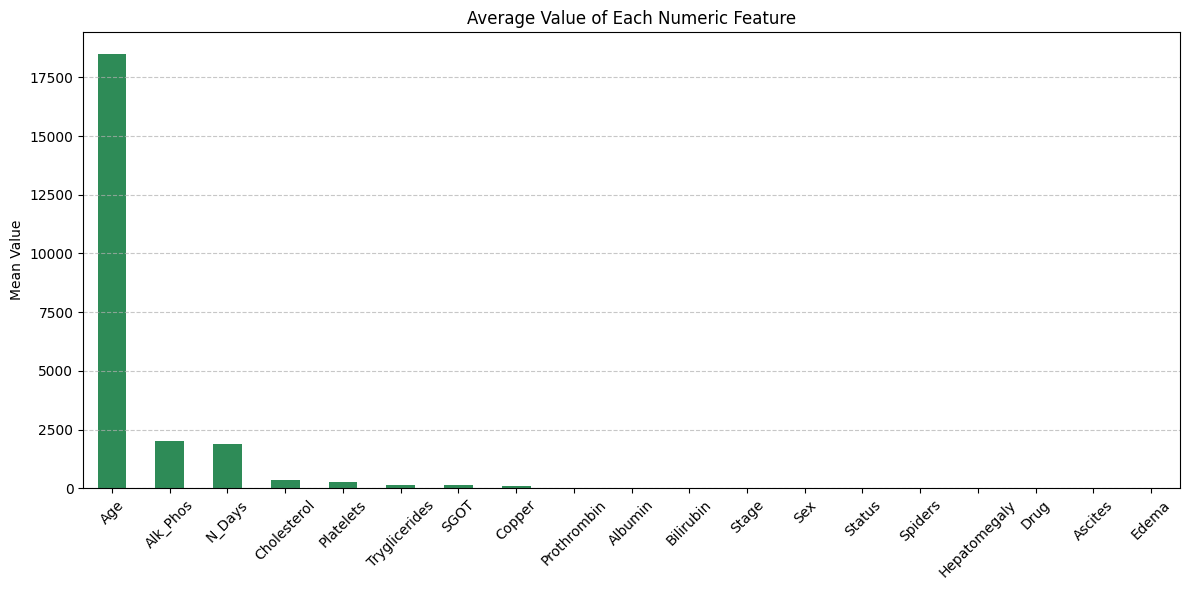

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12, 6))
data_frame.select_dtypes(include='number').mean().sort_values(ascending=False).plot(kind='bar', color='seagreen')
plt.title('Average Value of Each Numeric Feature')
plt.ylabel('Mean Value')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

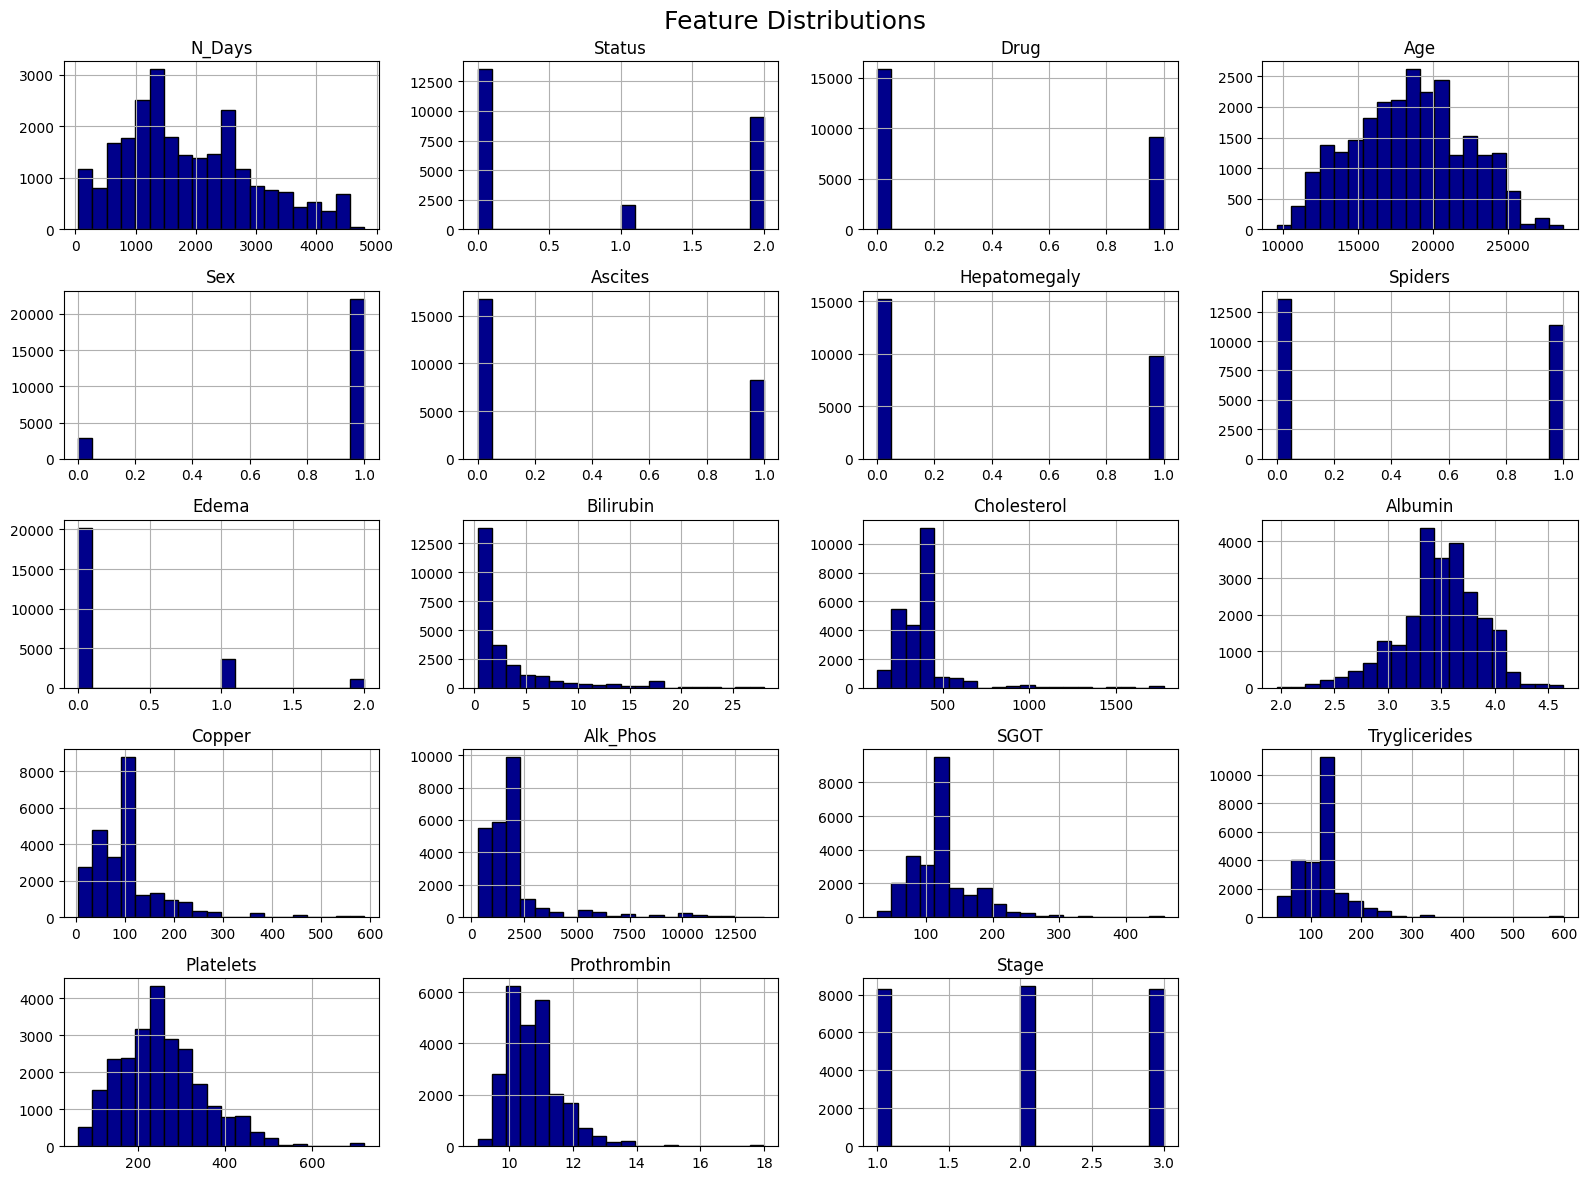

In [14]:
data_frame.hist(figsize=(16, 12), bins=20, color='darkblue', edgecolor='black')
plt.suptitle('Feature Distributions', fontsize=18)
plt.tight_layout()
plt.show()

In [15]:
data_frame.isnull().sum()

N_Days           0
Status           0
Drug             0
Age              0
Sex              0
Ascites          0
Hepatomegaly     0
Spiders          0
Edema            0
Bilirubin        0
Cholesterol      0
Albumin          0
Copper           0
Alk_Phos         0
SGOT             0
Tryglicerides    0
Platelets        0
Prothrombin      0
Stage            0
dtype: int64

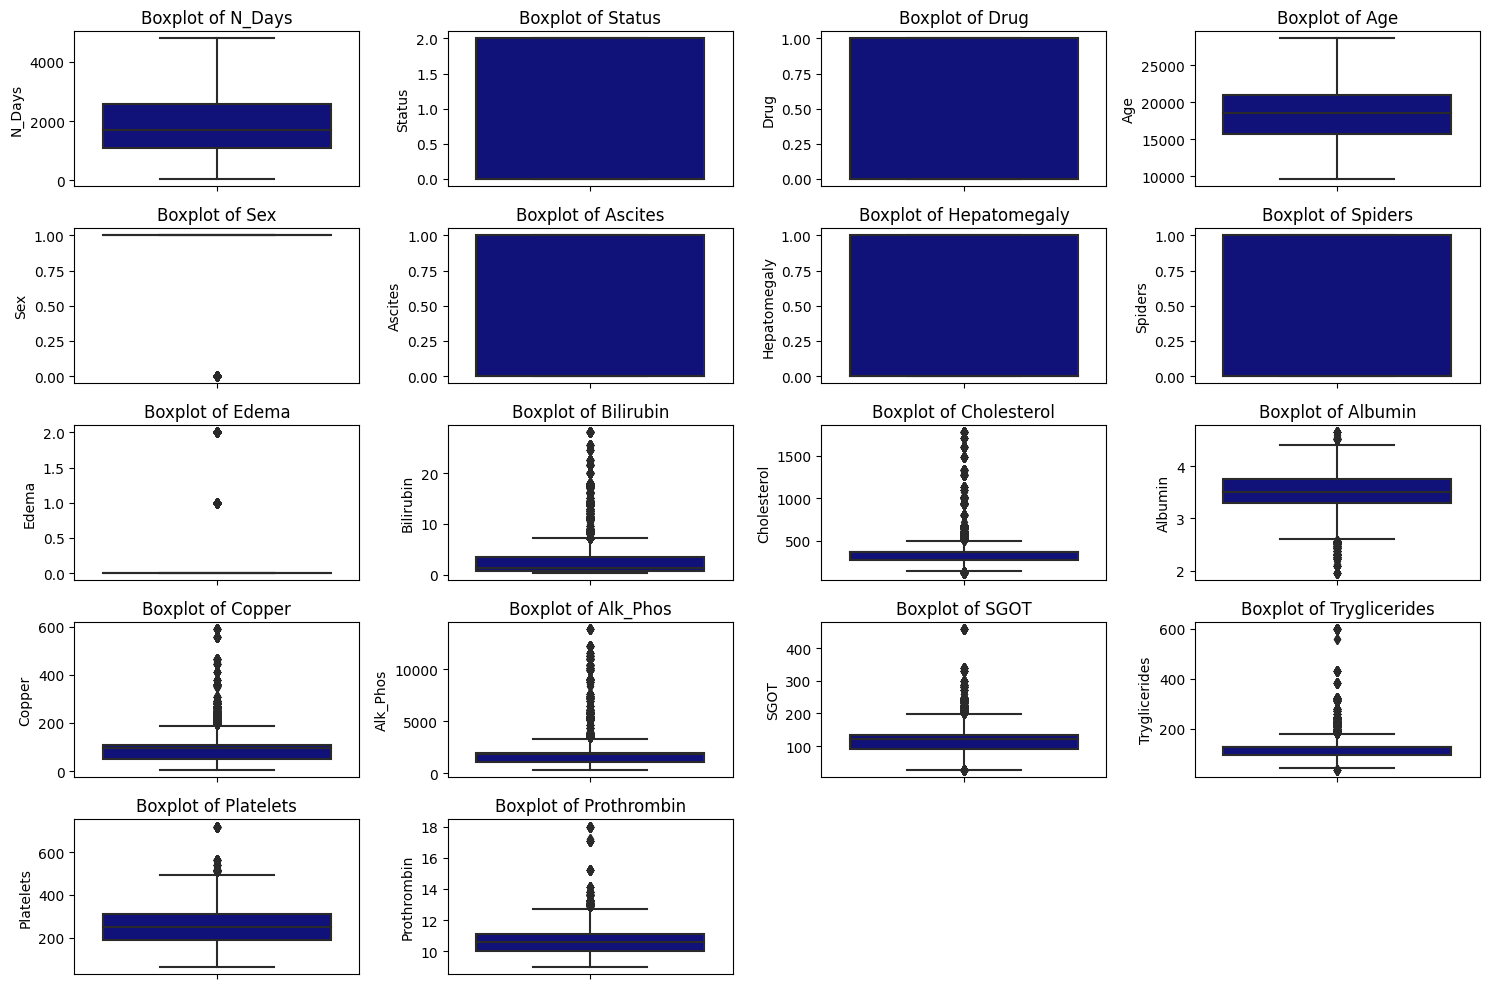

In [16]:
plt.figure(figsize=(15,10))
for i, column in enumerate(data_frame.columns[:-1]):  
    plt.subplot(5, 4, i + 1)
    sns.boxplot(y=data_frame[column], color='darkblue')
    plt.title(f'Boxplot of {column}')
plt.tight_layout()
plt.show()

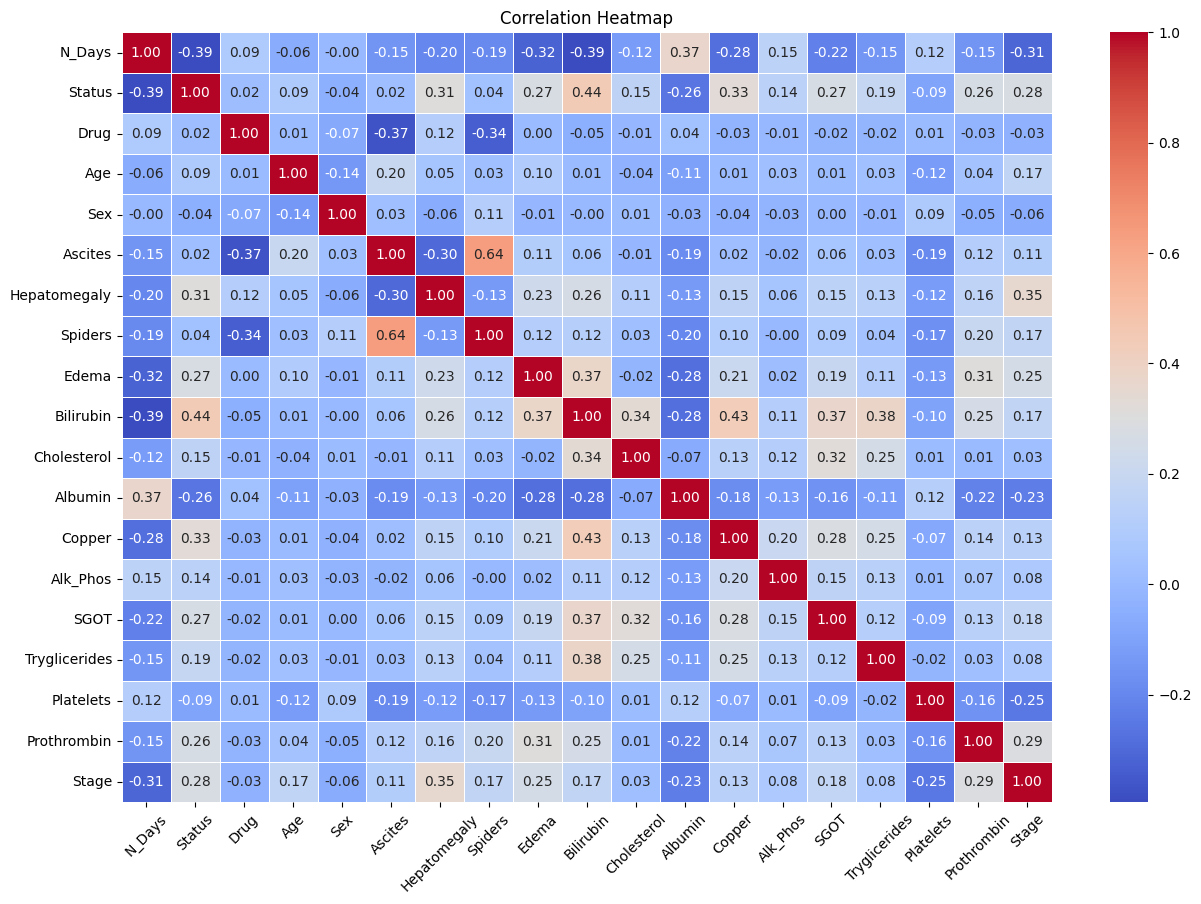

In [17]:
plt.figure(figsize=(15, 10))
corr_matrix = data_frame.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.xticks(rotation=45)
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

In [ ]:
outlier_cols = [
    'Bilirubin', 'Cholesterol', 'Copper', 'Alk_Phos',
    'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin'
]

for col in outlier_cols:
    data_frame = remove_outliers_iqr(data_frame, col)

print("Shape after outlier removal:", data_frame.shape)

In [18]:
data_frame['Age_Years'] = data_frame['Age'] / 365
data_frame.drop('Age', axis=1, inplace=True)

# ***Training***

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = data_frame.drop(columns=['Stage'])  
y = data_frame['Stage']                 

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

# ***SUPPORT VECTOR MACHINE (SVM) MODEL***

In [24]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

# defining parmeter range
param_grid = {'C':[0.1,1,10,100,1000],
              'gamma':[1,0.1,0.01,0.001,0.0001],
              'kernel':['rbf','pol','sigmoid']}

grid = GridSearchCV(SVC(),param_grid=param_grid,refit=True,cv=5,verbose=3)
grid.fit(X_train,y_train)

Fitting 5 folds for each of 75 candidates, totalling 375 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.837 total time=  16.5s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.835 total time=  16.8s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.824 total time=  16.8s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.828 total time=  16.8s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.834 total time=  16.8s
[CV 1/5] END ..........C=0.1, gamma=1, kernel=pol;, score=nan total time=   0.0s
[CV 2/5] END ..........C=0.1, gamma=1, kernel=pol;, score=nan total time=   0.0s
[CV 3/5] END ..........C=0.1, gamma=1, kernel=pol;, score=nan total time=   0.0s
[CV 4/5] END ..........C=0.1, gamma=1, kernel=pol;, score=nan total time=   0.0s
[CV 5/5] END ..........C=0.1, gamma=1, kernel=pol;, score=nan total time=   0.0s
[CV 1/5] END ....C=0.1, gamma=1, kernel=sigmoid;, score=0.390 total time=  18.8s
[CV 2/5] END ....C=0.1, gamma=1, kernel=sigmoid

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf', 'pol', 'sigmoid']},
             verbose=3)

In [25]:
grid.best_params_

{'C': 1000, 'gamma': 0.1, 'kernel': 'rbf'}

In [27]:
y_pred=grid.predict(X_test)

print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))

              precision    recall  f1-score   support

           1       0.89      0.90      0.89      1653
           2       0.89      0.89      0.89      1688
           3       0.92      0.92      0.92      1659

    accuracy                           0.90      5000
   macro avg       0.90      0.90      0.90      5000
weighted avg       0.90      0.90      0.90      5000

[[1480  119   54]
 [ 116 1500   72]
 [  68   72 1519]]


# ***Decision TREE***

In [46]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

decision_tree_classifier=DecisionTreeClassifier(random_state=42)
decision_tree_classifier.fit(X_train,y_train)


DecisionTreeClassifier(random_state=42)

 Decision Tree Classifer
--------------------------------------------------------------------------- Accuracy ---------------------------------------------------------------------------
 Accuracy: 0.9098
--------------------------------------------------------------------------- Classification Report ---------------------------------------------------------------------------
 Classification Report:
               precision    recall  f1-score   support

           1       0.91      0.90      0.90      1653
           2       0.89      0.90      0.90      1688
           3       0.93      0.93      0.93      1659

    accuracy                           0.91      5000
   macro avg       0.91      0.91      0.91      5000
weighted avg       0.91      0.91      0.91      5000

--------------------------------------------------------------------------- Confusion Matrix ---------------------------------------------------------------------------


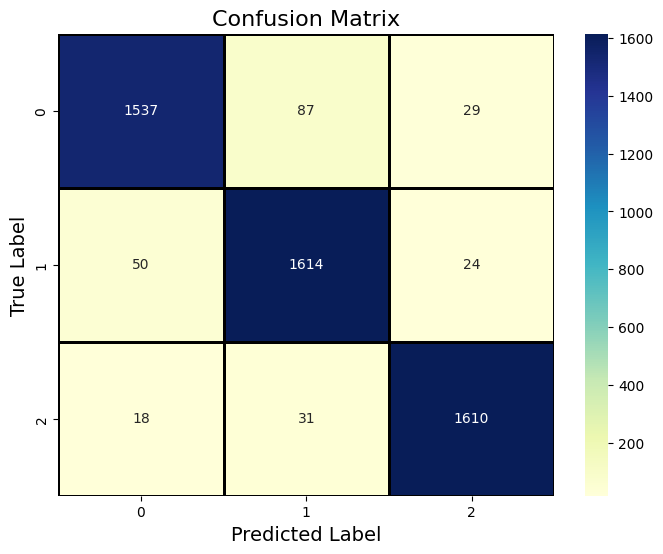

In [50]:
y_pred=decision_tree_classifier.predict(X_test)
print(" Decision Tree Classifer")
print("-"*75,"Accuracy","-"*75)
print(" Accuracy:", accuracy_score(y_test, y_pred))
print("-"*75,"Classification Report","-"*75)
print(" Classification Report:\n", classification_report(y_test, y_pred))
print("-"*75,"Confusion Matrix","-"*75)
cm_log = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", cbar=True, linewidths=1, linecolor='black')
plt.title("Confusion Matrix", fontsize=16)
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)
plt.show()

# ***Random Forest Classifier***

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [29]:
y = data_frame['Stage']
X = data_frame.drop(columns=['Stage'])

In [30]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [31]:
y_pred = rf_model.predict(X_test)

In [32]:
print("\n Test Accuracy:", accuracy_score(y_test, y_pred))
print("\n Classification Report:\n", classification_report(y_test, y_pred))


✅ Test Accuracy: 0.9522

📄 Classification Report:
               precision    recall  f1-score   support

           1       0.96      0.93      0.94      1653
           2       0.93      0.96      0.94      1688
           3       0.97      0.97      0.97      1659

    accuracy                           0.95      5000
   macro avg       0.95      0.95      0.95      5000
weighted avg       0.95      0.95      0.95      5000



In [36]:
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(rf_model, X, y, cv=5, scoring='accuracy')

In [38]:
print(" Cross-Validation Accuracies (5-fold):", cv_scores)
print(" Mean CV Accuracy: {:.4f}".format(cv_scores.mean()))
print(" Standard Deviation: {:.4f}".format(cv_scores.std()))

 Cross-Validation Accuracies (5-fold): [0.943  0.9438 0.9446 0.947  0.9636]
 Mean CV Accuracy: 0.9484
 Standard Deviation: 0.0077


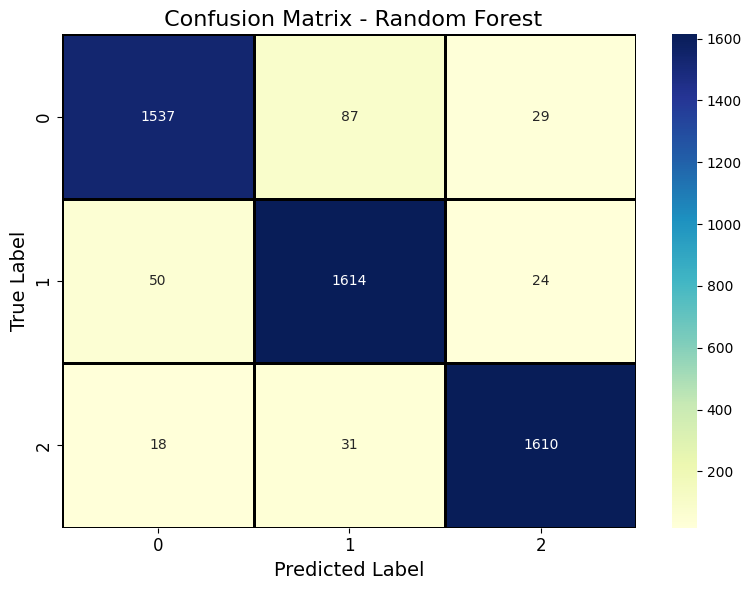

In [34]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", linewidths=1, linecolor='black')
plt.title(" Confusion Matrix - Random Forest", fontsize=16)
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

# ***XG BOOST***

In [67]:
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

le = LabelEncoder()
y_encoded = le.fit_transform(data_frame['Stage'])  

In [68]:
X = data_frame.drop(columns=['Stage'])
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

In [69]:
xgb_model = xgb.XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

In [70]:
y_pred = xgb_model.predict(X_test)

In [71]:
from sklearn.metrics import classification_report

target_names = [str(cls) for cls in le.classes_]
print("\n Test Accuracy: {:.4f}".format(accuracy_score(y_test, y_pred)))
print("\n Classification Report:\n", classification_report(y_test, y_pred, target_names=target_names))


✅ Test Accuracy: 0.9650

📄 Classification Report:
               precision    recall  f1-score   support

           1       0.97      0.95      0.96      1657
           2       0.95      0.97      0.96      1697
           3       0.97      0.97      0.97      1646

    accuracy                           0.96      5000
   macro avg       0.97      0.97      0.97      5000
weighted avg       0.97      0.96      0.97      5000



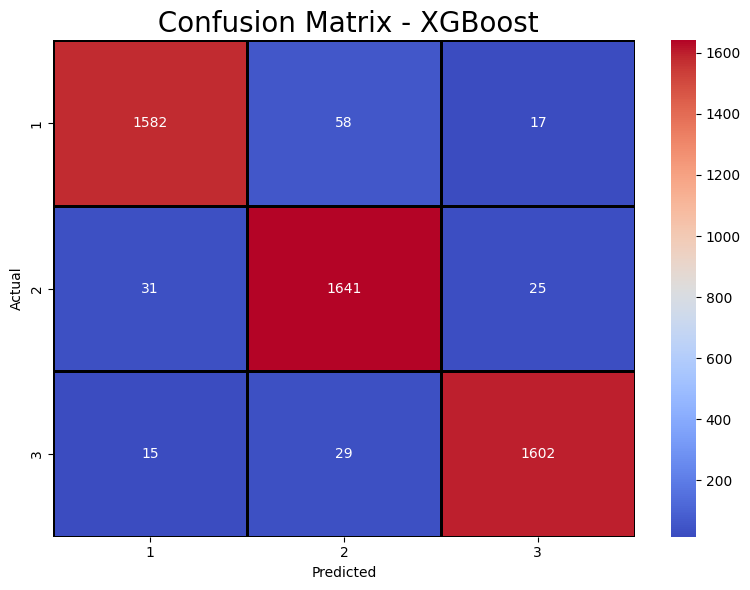

In [72]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", linewidths=1, linecolor='black',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title(" Confusion Matrix - XGBoost", fontsize=20)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# ***Logistic Regression***

In [82]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter=1000, solver='lbfgs', multi_class='auto')
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [83]:
y_pred = log_reg.predict(X_test)

In [84]:
print("\n✅ Test Accuracy:", accuracy_score(y_test, y_pred))
print("\n📄 Classification Report:\n", classification_report(y_test, y_pred))


✅ Test Accuracy: 0.534

📄 Classification Report:
               precision    recall  f1-score   support

           0       0.54      0.57      0.55      1657
           1       0.49      0.38      0.43      1697
           2       0.57      0.65      0.61      1646

    accuracy                           0.53      5000
   macro avg       0.53      0.54      0.53      5000
weighted avg       0.53      0.53      0.53      5000



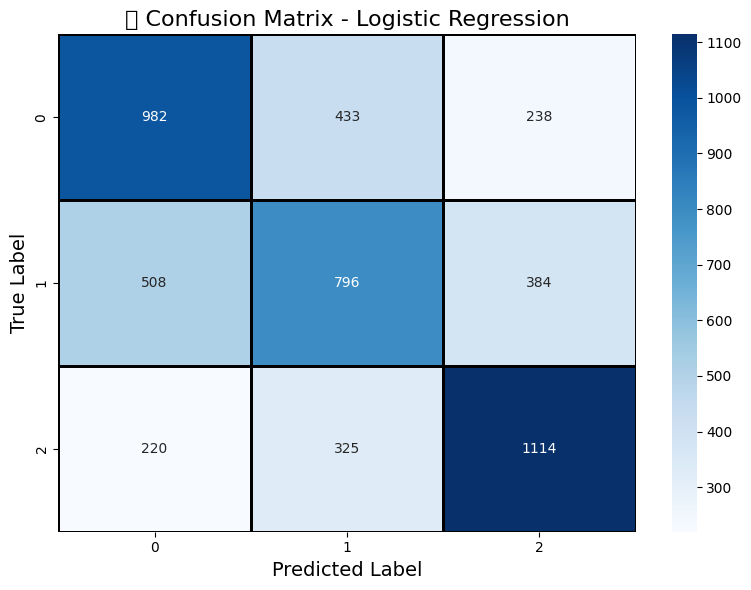


📊 Cross-Validation Accuracies (5-fold): [0.53   0.5136 0.52   0.525  0.5422]
✅ Mean CV Accuracy: 0.5262
📉 Standard Deviation: 0.0097


In [54]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=1, linecolor='black')
plt.title(" Confusion Matrix - Logistic Regression", fontsize=16)
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)
plt.tight_layout()
plt.show()
cv_scores = cross_val_score(log_reg, X, y, cv=5, scoring='accuracy')
print("\n Cross-Validation Accuracies (5-fold):", cv_scores)
print(" Mean CV Accuracy: {:.4f}".format(cv_scores.mean()))
print(" Standard Deviation: {:.4f}".format(cv_scores.std()))

# ***K-Nearest Neighbour Classifier***

In [73]:
from sklearn.neighbors import KNeighborsClassifier

target_names = [str(cls) for cls in le.classes_] if 'le' in locals() else None

In [74]:
knn_model = KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2)  
knn_model.fit(X_train, y_train)

KNeighborsClassifier()

In [75]:
y_pred = knn_model.predict(X_test)

In [80]:
print("\n Test Accuracy: {:.4f}".format(accuracy_score(y_test, y_pred)))
print("\n Classification Report:\n", classification_report(y_test, y_pred, target_names=target_names))


 Test Accuracy: 0.8754

 Classification Report:
               precision    recall  f1-score   support

           1       0.87      0.86      0.86      1657
           2       0.85      0.87      0.86      1697
           3       0.91      0.89      0.90      1646

    accuracy                           0.88      5000
   macro avg       0.88      0.88      0.88      5000
weighted avg       0.88      0.88      0.88      5000



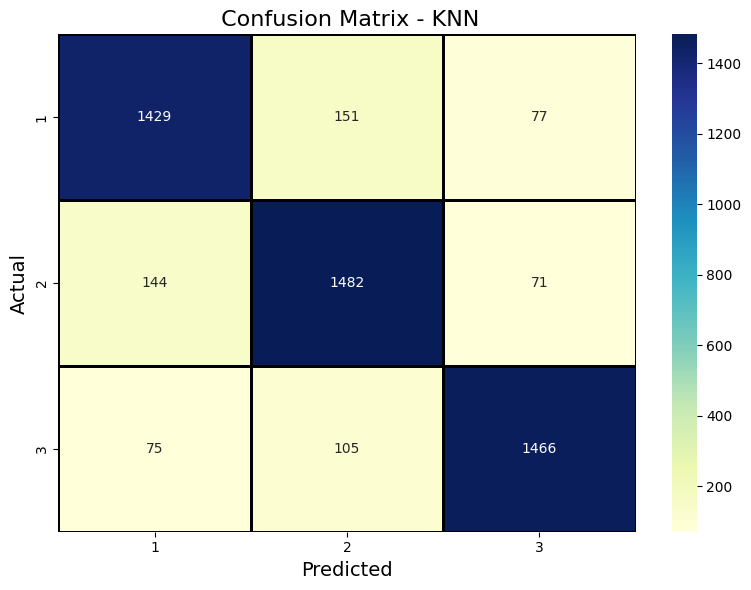

In [79]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", linewidths=1, linecolor='black',
            xticklabels=target_names, yticklabels=target_names)
plt.title(" Confusion Matrix - KNN", fontsize=16)
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("Actual", fontsize=14)
plt.tight_layout()
plt.show()